# Inversion of geophysical data

In [1]:
# Common imports
import numpy as np
from matplotlib import pyplot as plt
import pygimli as pg
from pygimli.physics.ert import createGeometricFactors, ERTManager
from pygimli.meshtools import createMesh
import pybert as pb

plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200

### Defining some usefull functions

In [2]:
def plotCompareResults(data, invResults):
    relError = ((abs(data['rhoa']-invResults))/data['rhoa'] * 100) # Relative error in % for each data point
    figComp = plt.figure(figsize=(10,5))
    ax2 = figComp.add_subplot(122)
    ax2.plot(data['rhoa'], invResults, 'bo', label='Full Data')
    ax2.axline((0,0), slope=1, color='k', label='Unity line')
    ax2.set_xlabel('Measured Apparent resistivities [Ohm.m]')
    ax2.set_ylabel('Computed Apparent resistivities [Ohm.m]')
    ax1 = figComp.add_subplot(121)
    ax1.hist(relError, color='b')
    ax1.set_xlabel('Relative error [%]')
    ax1.set_ylabel('Number of data points')
    plt.plot()
    return

### File system and names

In [3]:
directory = './VSL_Data/'
dataFile = 'Line2_Gradient7.dat'
hasIP = False
saveDir = 'Save_Line2/'

### Base inversion and parameters

31/03/22 - 12:19:48 - pyGIMLi - INFO - Cache C:\Software\Anaconda3\envs\BERT\lib\site-packages\pygimli\physics\ert\ert.py:createGeometricFactors restored (5.5s x 1): C:\Users\hadri\AppData\Roaming\pygimli\Cache\2696794035913590725
31/03/22 - 12:19:48 - pyGIMLi - INFO - Found 2 regions.
31/03/22 - 12:19:48 - pyGIMLi - INFO - Region with smallest marker (1) set to background
31/03/22 - 12:19:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
31/03/22 - 12:19:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


(<AxesSubplot:>, None)

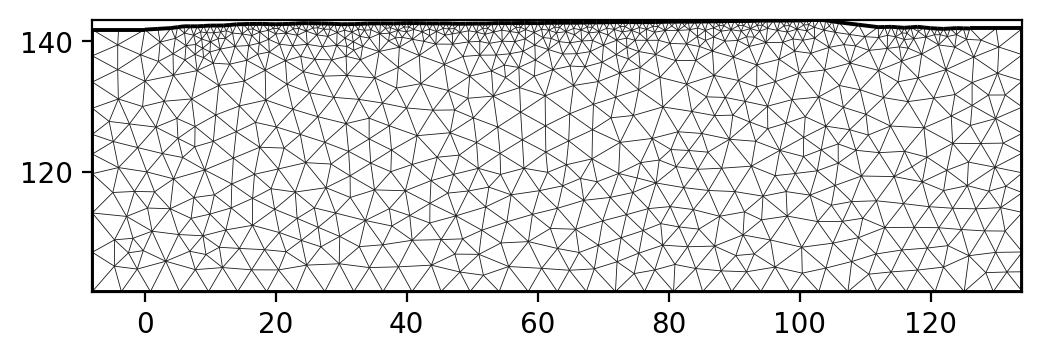

In [4]:
# Loading the dataset
if hasIP:
    tdip = pb.TDIPdata(directory+dataFile)
    data = tdip.data
else:
    data = pg.load(directory+dataFile)

# meshInit = createMesh(data.sensors())
if not data.allNonZero('k'):
    data['k'] = createGeometricFactors(data, numerical=True)
if not data.allNonZero('rhoa'):
    data['rhoa'] = data['r']*data['k']
if not data.allNonZero('err'):
    absoluteError = 0.001
    relativeError = 0.03
    data['err'] = relativeError + absoluteError / data['rhoa']

mgr = ERTManager(data)
# Mesh creation
paraDepth = 40 # Depth to obtain at any points on the profile
quality = 33.6
paraMaxCellSize = 2.5
paraDX = 1
# Changes to the paraDepth 
positions = data.sensors()
meshInit = mgr.createMesh(data, paraDepth=paraDepth, quality=quality-2, paraMaxCellSize=paraMaxCellSize*4, paraDX=paraDX)
mgr.setMesh(meshInit)

pg.show(mgr.paraDomain)


### Inversion of the data (round 1)

31/03/22 - 12:19:49 - pyGIMLi - INFO - Found 2 regions.
31/03/22 - 12:19:49 - pyGIMLi - INFO - Region with smallest marker (1) set to background
31/03/22 - 12:19:49 - pyGIMLi - INFO - Creating forward mesh from region infos.
31/03/22 - 12:19:49 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
31/03/22 - 12:19:49 - pyGIMLi - INFO - Starting inversion.
31/03/22 - 12:19:49 - pyGIMLi - INFO - Set default startmodel to median(data values)=153.54092633012937
31/03/22 - 12:19:49 - pyGIMLi - INFO - Created startmodel from forward operator: 1468 [153.54092633012937,...,153.54092633012937]


fop: <pygimli.physics.ert.ert.ERTModelling object at 0x000001D6418327B0>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x000001D641838DF0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x000001D62AB73AF0>
min/max (data): 64.67/306
min/max (error): 0.070%/6.09%
min/max (start model): 154/154
--------------------------------------------------------------------------------


C:\Software\Anaconda3\envs\BERT\lib\site-packages\pygimli\viewer\mpl\colorbar.py:448: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  mappable.get_cmap().set_bad([1.0, 1.0, 1.0, 0.0])


(<AxesSubplot:>, <matplotlib.colorbar.Colorbar at 0x1d64ba75208>)

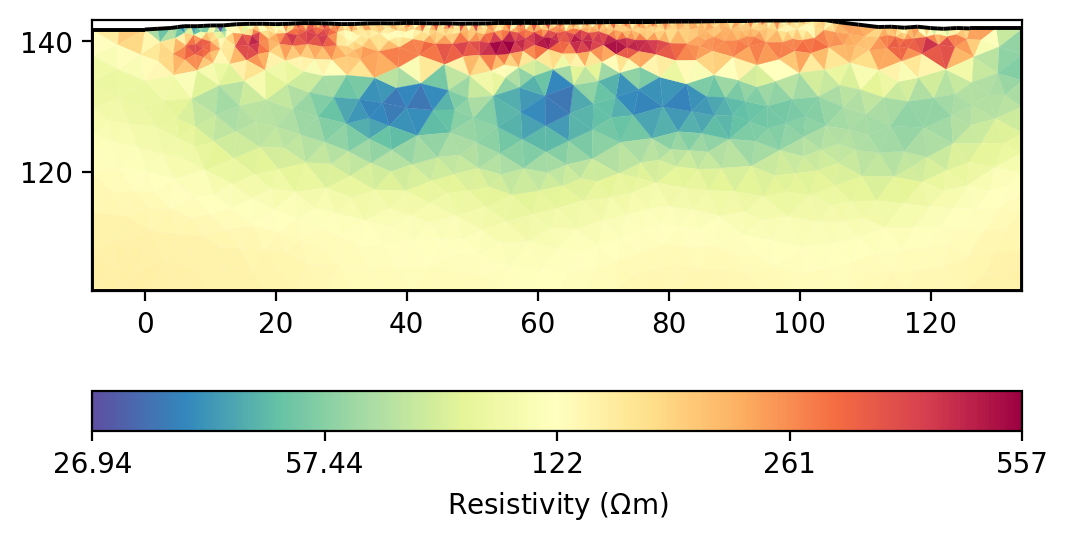

In [5]:
mgr.checkData(data)
lam = 20
verbose = True
robustData = True
chi1Opt = False # Optimize lambda for chi2 = 1
# Initialization inversion
mod = mgr.invert(mesh=meshInit, lam=lam, verbose=verbose, maxIter=1)

# Setting parameters for controled inversion
inv = mgr.fw.inv
inv.setRobustData(robustData)
inv.setVerbose(verbose)
inv.setLambda(lam)
inv.setDeltaPhiAbortPercent(1)

mod = inv.run()

mgr.showResult(model=mod)

### Using this inversion, we filter the data and re-run the inversion on a finner mesh (round 2)
The first inversion is run. We will use this to eventually filter the data.

The inversion leads to an acceptable relative rms (1.7700750077246137 %).


31/03/22 - 12:20:37 - pyGIMLi - INFO - Found 2 regions.
31/03/22 - 12:20:37 - pyGIMLi - INFO - Region with smallest marker (1) set to background
31/03/22 - 12:20:37 - pyGIMLi - INFO - Creating forward mesh from region infos.
31/03/22 - 12:20:38 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
31/03/22 - 12:20:38 - pyGIMLi - INFO - Starting inversion.
31/03/22 - 12:20:38 - pyGIMLi - INFO - Set default startmodel to median(data values)=153.54092633012937
31/03/22 - 12:20:38 - pyGIMLi - INFO - Created startmodel from forward operator: 4577 [153.54092633012937,...,153.54092633012937]


fop: <pygimli.physics.ert.ert.ERTModelling object at 0x000001D660F1A670>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x000001D660F22E30>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x000001D660F22EF0>
min/max (data): 64.67/306
min/max (error): 0.070%/6.09%
min/max (start model): 154/154
--------------------------------------------------------------------------------


C:\Software\Anaconda3\envs\BERT\lib\site-packages\pygimli\viewer\mpl\colorbar.py:448: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  mappable.get_cmap().set_bad([1.0, 1.0, 1.0, 0.0])


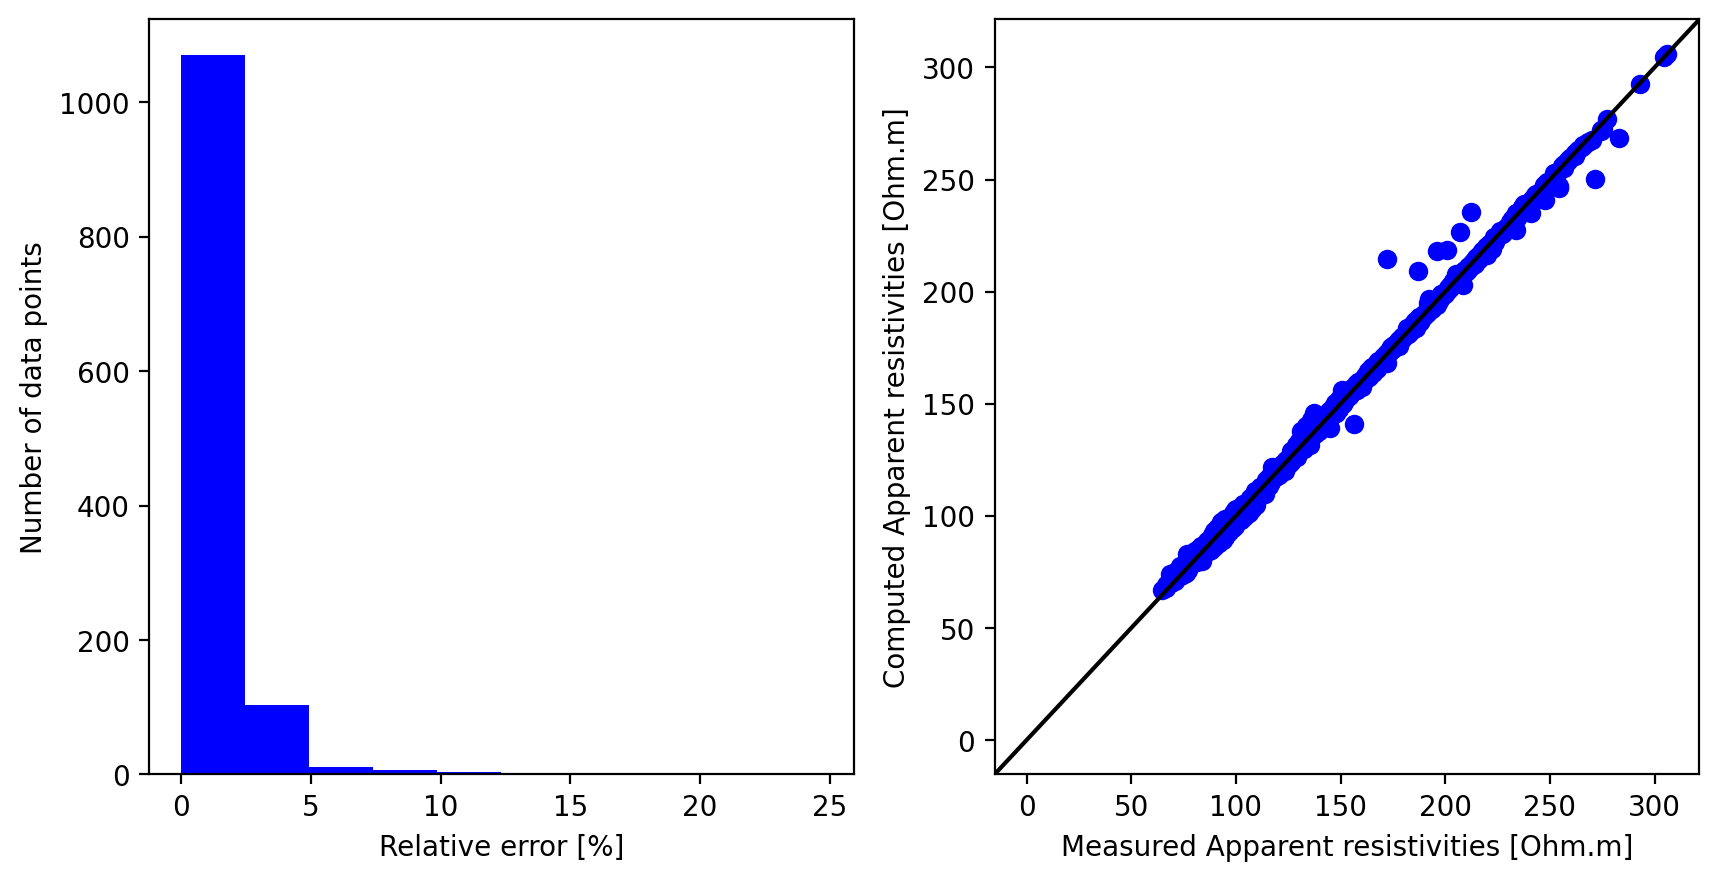

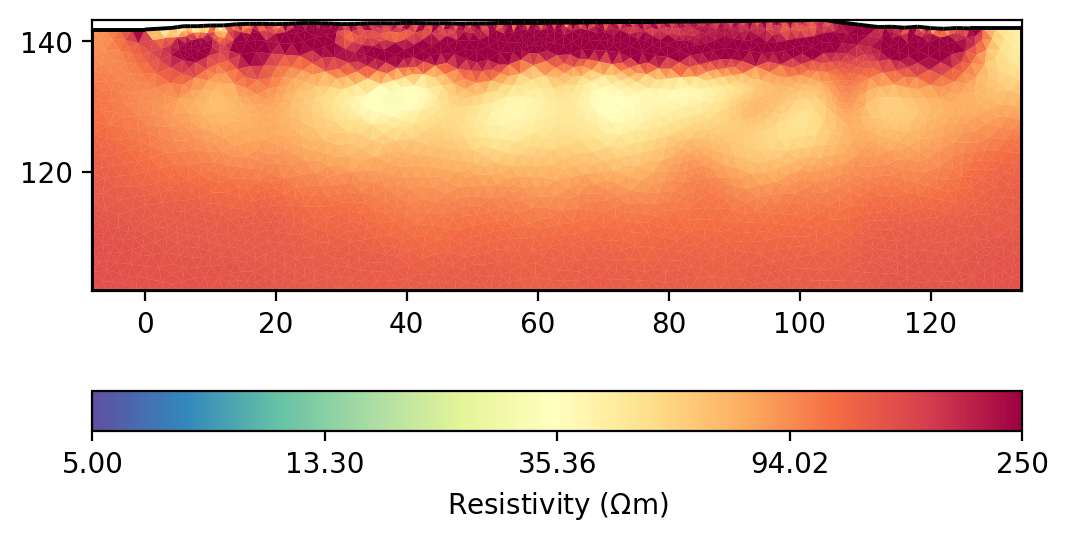

In [6]:
relError = ((abs(data['rhoa']-inv.response()))/data['rhoa'] * 100) # Relative error in % for each data point
cutOffError = 10 # Maximum accepted relative error on the reconstruction (%)
# Plotting the graph with the datasets misfit:
# figComp = plt.figure(figsize=(10,5))
# ax2 = figComp.add_subplot(122)
# ax2.plot(data['rhoa'], inv.response(), 'bo', label='Full Data')
# ax2.axline((0,0), slope=1, color='k', label='Unity line')
# ax2.set_xlabel('Measured Apparent resistivities [Ohm.m]')
# ax2.set_ylabel('Computed Apparent resistivities [Ohm.m]')
# ax1 = figComp.add_subplot(121)
# ax1.hist(relError, color='b')
# ax1.set_xlabel('Relative error [%]')
# ax1.set_ylabel('Number of data points')
plotCompareResults(data, inv.response())
if inv.relrms() > 5:
    print(f'The inversion leads to a rather high relative rms ({inv.relrms()} %). We will filter the data!')
    idxRemove = relError > cutOffError
    idxKeep = [not(i) for i in idxRemove]
    print(f'Out of the initial {len(idxRemove)} data points, {sum(idxKeep)} are kept for inversion.')
    data.remove(idxRemove)
    data.save(directory + saveDir + 'TrimmedDataset.ohm')
    idxKeep = [not(i) for i in idxRemove]
    relErrorBis = ((abs(data['rhoa']-np.asarray(inv.response())[idxKeep]))/data['rhoa'] * 100)
    # Adding the set about the removed datapoints to the graphs:
    # ax1.hist(relErrorBis, color='r')
    # ax2.plot(data['rhoa'], inv.response()[idxKeep], 'ro', label='Trimmed Dataset')
    plotCompareResults(data, np.asarray(inv.response())[idxKeep])
else:
    print(f'The inversion leads to an acceptable relative rms ({inv.relrms()} %).')
# Re-run the inversion on a finner mesh:
mgr = ERTManager(data)
mesh = mgr.createMesh(data, paraDepth=paraDepth, quality=quality, paraMaxCellSize=paraMaxCellSize, paraDX=paraDX)
modInit = mgr.invert(data, mesh, lam=lam, verbose=verbose, maxIter=1)
inv = mgr.fw.inv
inv.setRobustData(robustData)
inv.setVerbose(verbose)
inv.setLambda(lam)
inv.setDeltaPhiAbortPercent(1)
if chi1Opt:
    mod = inv.runChi1()
else:
    mod = inv.run()
# Present the results of the inversion:
mgr.showResult(model=mod, cMin=5, cMax=250)
# mgr.showFit(model=mod)
plt.show()

The inversion run leads to a relative rms of 1.5958369690358458 % (chi² = 0.6922354443664073) in 6 iterations.


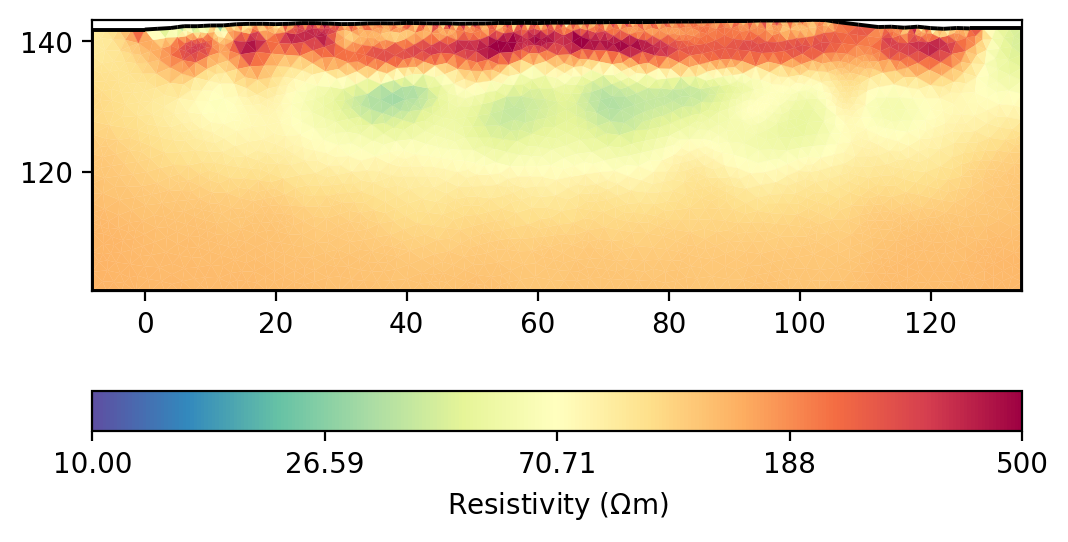

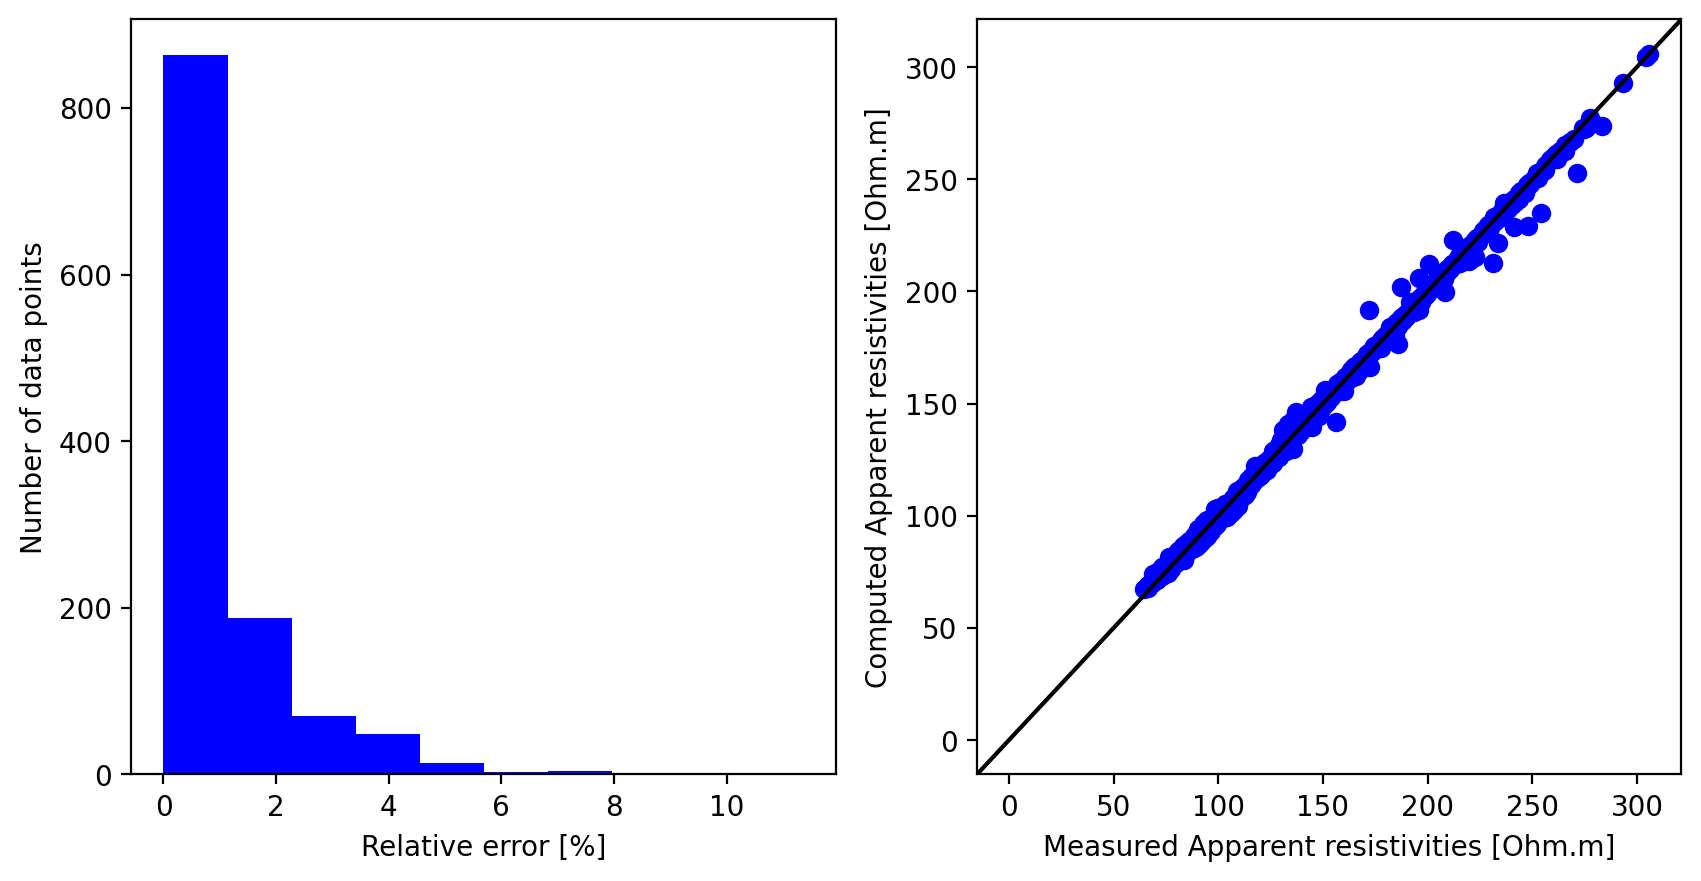

In [7]:
print(f'The inversion run leads to a relative rms of {inv.relrms()} % (chi² = {inv.chi2()}) in {inv.iter()} iterations.')
mgr.showResult(model=mod, cMin=10, cMax=500)
plotCompareResults(data, inv.response())
m = pg.Mesh(mgr.paraDomain)
m['Resistivity'] = mgr.paraModel(mod)
m['Coverage'] = mgr.paraModel(mgr.coverage())
m.exportVTK(directory + saveDir + 'invResults.vtk')

### Computing the DOI index for the model

First model at 0.1 x median resistivity

In [8]:
medRhoa = np.median(data['rhoa'])
paraDepthDOI = paraDepth * 5
mgrDOI1 = ERTManager(data)
mgrDOI2 = ERTManager(data)
meshDOI = mgrDOI1.createMesh(data, paraDepth=paraDepthDOI, paraMaxCellSize=paraMaxCellSize*5, quality=33.6, paraDX=paraDX)

modDefault = mgrDOI1.invert(data, meshDOI, maxIter=1)
_ = mgrDOI2.invert(data, meshDOI, maxIter=1)
ref1 = modDefault * 0 + medRhoa*10
ref2 = modDefault * 0 + medRhoa/10
inv1 = mgrDOI1.fw.inv
inv2 = mgrDOI2.fw.inv
rm1 = mgrDOI1.inv.fop.regionManager()
rm2 = mgrDOI2.inv.fop.regionManager()
rm1.setConstraintType(0) # 0 = reference model, 1 = first-order smoothing (default), 10 = both
rm1.fillConstraints(mgrDOI1.inv.fop.constraints())
rm2.setConstraintType(0) # 0 = reference model, 1 = first-order smoothing (default), 10 = both
rm2.fillConstraints(mgrDOI2.inv.fop.constraints())
inv1.setRobustData(robustData)
inv1.setVerbose(verbose)
inv1.setLambda(lam)
inv1.setDeltaPhiAbortPercent(1)
inv2.setRobustData(robustData)
inv2.setVerbose(verbose)
inv2.setLambda(lam)
inv2.setDeltaPhiAbortPercent(1)
inv1.setReferenceModel(ref1)
inv2.setReferenceModel(ref2)
inv1.setModel(ref1)
inv2.setModel(ref2)

31/03/22 - 12:23:48 - pyGIMLi - INFO - Found 2 regions.
31/03/22 - 12:23:48 - pyGIMLi - INFO - Region with smallest marker (1) set to background
31/03/22 - 12:23:48 - pyGIMLi - INFO - Creating forward mesh from region infos.
31/03/22 - 12:23:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
31/03/22 - 12:23:49 - pyGIMLi - INFO - Set default startmodel to median(data values)=153.54092633012937
31/03/22 - 12:23:49 - pyGIMLi - INFO - Created startmodel from forward operator: 4614 [153.54092633012937,...,153.54092633012937]
31/03/22 - 12:25:07 - pyGIMLi - INFO - Found 2 regions.
31/03/22 - 12:25:07 - pyGIMLi - INFO - Region with smallest marker (1) set to background
31/03/22 - 12:25:07 - pyGIMLi - INFO - Creating forward mesh from region infos.
31/03/22 - 12:25:07 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
31/03/22 - 12:25:07 - pyGIMLi - INFO - Set default startmodel to median(data values)=153.54092633012937
31/03/22 - 12:25:07 - pyGIMLi - IN

In [9]:
if chi1Opt:
    mod1 = inv1.runChi1()
    mod2 = inv2.runChi1()
else:
    mod1 = inv1.run()
    mod2 = inv2.run()

Computing the DOI index:

C:\Software\Anaconda3\envs\BERT\lib\site-packages\pygimli\viewer\mpl\colorbar.py:448: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  mappable.get_cmap().set_bad([1.0, 1.0, 1.0, 0.0])


(<AxesSubplot:>, <matplotlib.colorbar.Colorbar at 0x1d6205ccd88>)

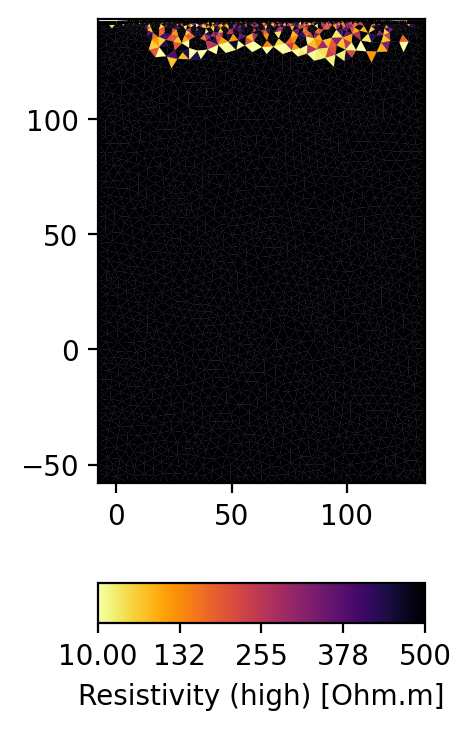

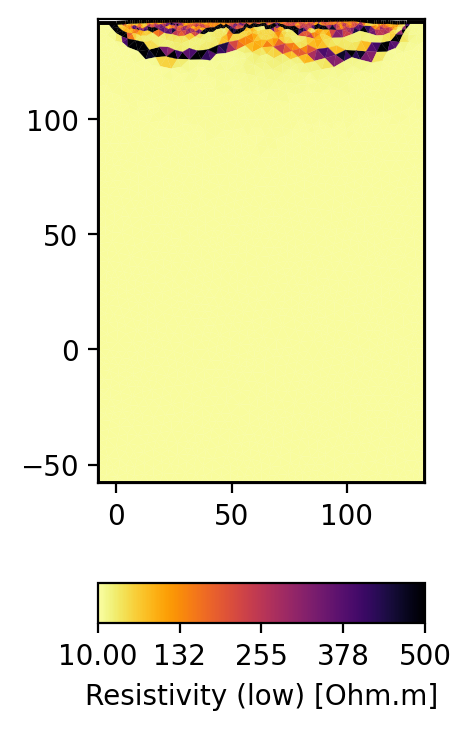

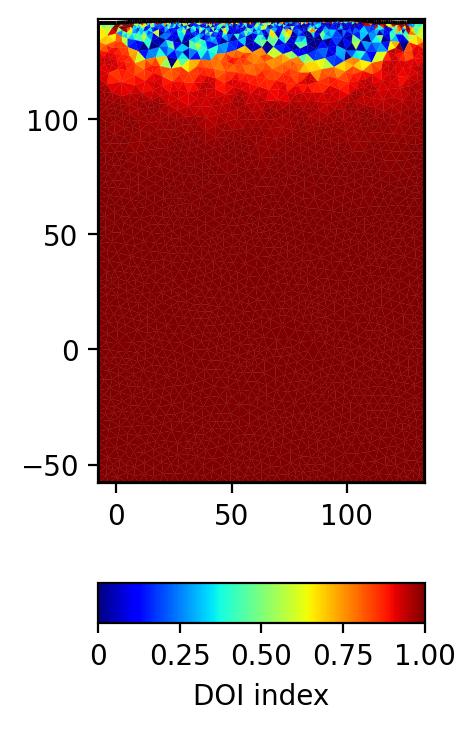

In [10]:
DOI = abs((mod1 - mod2) / (ref1 - ref2))
normDOI = DOI/max(DOI)
m = pg.Mesh(mgrDOI1.paraDomain)
m['Resistivity (high)'] = mgrDOI1.paraModel(mod1)
m['Resistivity (low)'] = mgrDOI1.paraModel(mod2)
m['DOI'] = mgrDOI1.paraModel(DOI)
m['Normalized DOI'] = mgrDOI1.paraModel(normDOI)
m.exportVTK(directory + saveDir + 'invDOI.vtk')

pg.show(mgrDOI1.paraDomain, mod1, cMin=10, cMax = 500, cMap='inferno_r', label='Resistivity (high) [Ohm.m]')
pg.show(mgrDOI1.paraDomain, mod2, cMin=10, cMax = 500, cMap='inferno_r', label='Resistivity (low) [Ohm.m]')
pg.show(mgrDOI1.paraDomain, DOI, cMin=0, cMax = 1, cMap='jet', label='DOI index')